<a href="https://colab.research.google.com/github/Hitomiblood/ProjectsDataScienceMaster/blob/main/NotebookPruebaGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Aprendizaje Profundo
### Nicolas Leonardo Maldonado - AX840282
### Miguel Santiago Gómez Suárez - AX751708
#### Uso de TPU's GPU's y CPU's en PyTorch

## Creación de Modelo de clasificación de Imagenes usando PyTorch y entrenando con GPU:
Realizamos toda la actualización e importación de librerías necesarias para el ejercicio.

In [1]:
!pip install -Uqq fastai --upgrade

In [2]:
from fastai.vision.all import *

Para el desarrollo del ejercicio se creará un modelo de clasificación de imágenes usando el dataSet de Chest_xray entregado en la practica 1.

In [3]:
%%capture
# Obtenemos el DataSet del Link, lo pasamos al Zip y lo descomprimimos
!wget https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1 -O chest_xray.zip
!unzip chest_xray.zip

In [4]:
path = Path('chest_xray/')
trainPath = path/'train'
testPath = path/'test'

Creamos nuestro DataBlock de Train y de Test. Hay que tener en cuenta que en función a la guía que se está siguiendo. Nos indican que las transformaciones a las imagenes se ejecutan en la CPU y son lentas, por ello es mejor unicamente usar la transformación de normalización.

In [5]:
# Creamos el dataBlock de Train
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.15,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(trainPath,bs=32) # Mantenemos el batch de 128, como en el ejemplo

# Creamos el dataBlock de test
dbTest = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(valid_name='test'),
    get_y=parent_label,
    item_tfms=Resize(512),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
    )

dlsTest = dbTest.dataloaders(path,bs=32)

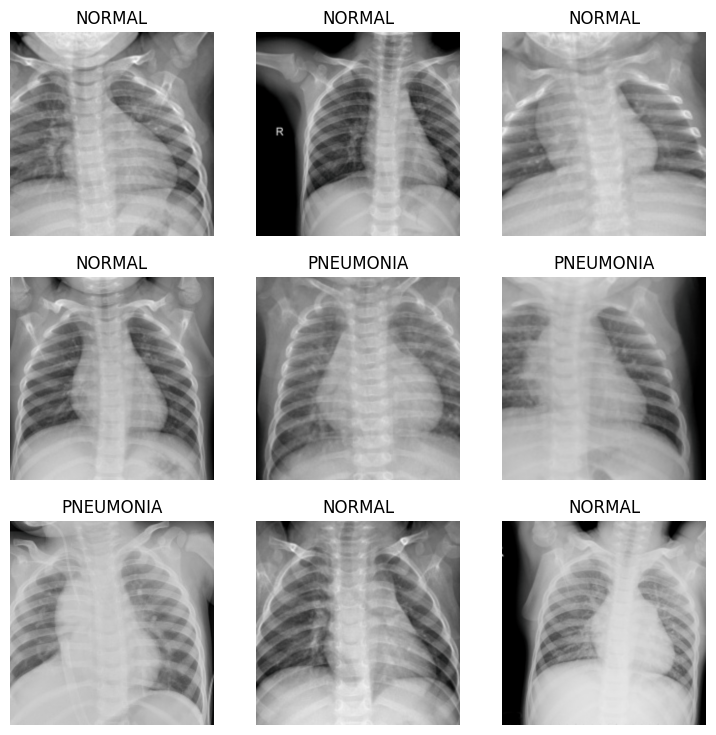

In [6]:
dls.show_batch()

Creamos el objeto Learner y mostramos el summary del mismo.

In [7]:
learner = cnn_learner(dls,resnet34,metrics=accuracy, concat_pool=False)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


In [8]:
learner.summary()

Sequential (Input shape: 32 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 256 x 256 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 128 x 128 
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0012022644514217973)

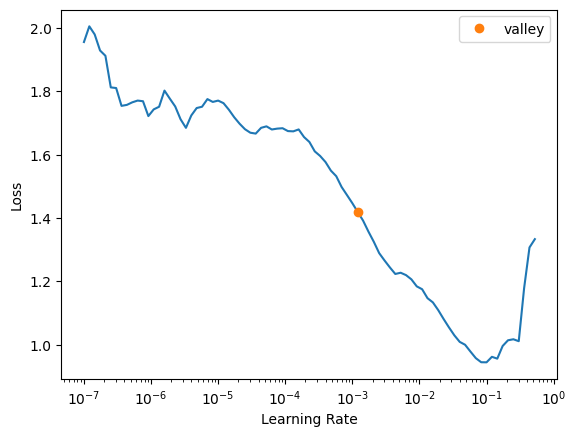

In [9]:
learner.lr_find()

In [10]:
one_param(learner.model).device

device(type='cuda', index=0)

Hacemos el proceso de entrenamiento y verificamos el tiempo que le toma realizarlo:

In [11]:
import time
start_time = time.time()
learner.fit_one_cycle(5,lr_max=slice(1e-4,0.02))
end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

epoch,train_loss,valid_loss,accuracy,time
0,0.404274,0.123796,0.968112,00:46
1,0.213971,0.061830,0.980867,00:46
2,0.117347,0.070113,0.979592,00:46
3,0.086375,0.045444,0.983418,00:46
4,0.060421,0.045832,0.980867,00:47


Tiempo de ejecución: 233.36978459358215 segundos


Hacemos el proceso de validación:

In [12]:
learner.dls = dlsTest
learner.validate()

(#2) [1.4192713499069214,0.7932692170143127]

Cargamos el Learner en HuggingFace:

In [13]:
!pip install huggingface_hub["fastai"] -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 7.8 MB/s eta 0:00:00


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from huggingface_hub import push_to_hub_fastai

repo_id = "Hitomiblood/CnnLearner_resnet34_chestXrayGPU"

push_to_hub_fastai(learner=learner, repo_id=repo_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  # Means the user did not define a `HF_TOKEN` secret => warn


model.pkl:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hitomiblood/CnnLearner_resnet34_chestXrayGPU/commit/a15194d75deaeb58cfab0e0bac779ab2c60c6990', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='a15194d75deaeb58cfab0e0bac779ab2c60c6990', pr_url=None, pr_revision=None, pr_num=None)